In [5]:
import ROOT
import math 
import time
import os
from array import array

Welcome to JupyROOT 6.22/02


In [15]:
LINECOLOR   = [1,2,3,4,5,6,7,8,9]
MARKERSTYLE = [8,8,8,8,8,8,8,8,8]
MARKERCOLOR = [1,2,3,4,5,6,7,8,9]

# Histogram directory:
DIR_IN = '/home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/histofiles/merged/'

# eras to draw ( + legend entry):
#ERAS=['22C','22D','22E','22F','22G', '22CDE','22FG','22all']
ERAS={
    '22CDE' : 'pre-HCAL update', 
    '22FG'  : 'post-HCAL update' ,
    '22all' : 'Full 2022',
}

VARLABELS = {
    'npv'  : 'Number of vertices',
    'pt1'  : 'Leading jet p_{T} [GeV]',
    'pt2'  : 'Sub-leading jet p_{T} [GeV]',
    'mjj' : 'm_{jj} [GeV]',
    'detajj' : '#Delta#eta(j1,j2)',
    'mass' : 'm_{SD} [GeV]',
    'myy' : 'm_{#gamma#gamma} [GeV]',
    'tag'  : 'DeepJet score',
    'tag2' : 'ParticleNet HbbVsQCD score',
    'ht'   : 'H_{T} [GeV]',
}

In [ ]:
# binnings
NPVBINS = [15,20,25,30,35,40,45,50,60]#,100]
TRIG_INFO = {
    ###########################################################################################
    'PNetbb' :         {
        'path' : 'HLT_AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35_v',
        'label' : 
        'HLT selection: #newline #geq 1 b-tagged large radius (R=0.8) jets, #newline p_{T}>250 GeV, m_{SD} > 40 GeV',  
        'var_binning' : {
            'pt1'  : [150,180,190,200,220,240,260,280,300,400,500,800],#1000],
            'tag'  : [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.01],
            'mass' : [0,25,50,70,80,90,100,110,120,130,140,150,200,250],
            'npv'  : NPVBINS,
        },
    },
    'VBFincl' :         {
        'path' : 'HLT_VBF_DiPFJet105_30_Mjj1000(_TripleJet)',
        'label' : 
        'Selection: #newline #geq 1 ak4 jets (tight ID), #newline p_{T1}>140 GeV, p_{T2}>70 GeV, #newline #Delta#eta(j1,j2)>3.5 #newline Ref.: IsoMu27, > 1 #mu (tight ID, pT > 30 GeV)',  
        'var_binning' : {
            'pt1'  : [150,180,190,200,220,240,260,280,300,400,500,800],#1000],
            'pt2'  : [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.01],
            'mjj' : [150,300,500,800,1000,1100,1200,1400,2000],
            'npv' : NPVBINS,
        },
    },
}


In [17]:

# Get efficiency TGraph for
def tgraph(fileIn, periodlabel='', varname='', outname='', style_idx=0, rebin=(0,[])):
    print("fileIn:",fileIn)
    thefile = ROOT.TFile(fileIn)
    print("lsfile:",thefile.ls())
    workdir = thefile.GetDirectory('VBFNanoAOD')
    print(outname, style_idx)
    print("h_{}{}passtrig".format((periodlabel+'_' if periodlabel!='' else ''), (varname+'_' if varname!='' else '')))
    print('rebin: ', rebin[1])
    print("lswdir:",workdir.ls())
    print("Numerator: ","h_{}{}passtrig".format(
        (periodlabel+'_' if periodlabel!='' else ''),
        (varname+'_' if (varname!='ht') else ''))
    )
    Numerator = workdir.Get("h_{}_pass".format(varname))
    Denominator = workdir.Get("h_{}_tot".format(varname))

    #print(Numerator.GetBinContent(15), Denominator.GetbinContent(15))
    #Numerator.Draw()
    if rebin[0]>0:
        print("rebin: ", rebin)
        nbin = rebin[0]
        bins = array('d',rebin[1])
        Numerator = Numerator.Rebin(nbin,  'Numerator', bins)
        Denominator = Denominator.Rebin(nbin,'Denominator', bins)
        #avoid overflow issues
        Numerator.SetBinContent(Numerator.GetNbinsX()+1,1)
        Denominator.SetBinContent(Denominator.GetNbinsX()+1,1)

    Efficiency = ROOT.TGraphAsymmErrors(Numerator,Denominator,outname)
    Efficiency.SetLineColor(LINECOLOR[style_idx])
    Efficiency.SetMarkerStyle(MARKERSTYLE[style_idx])
    Efficiency.SetMarkerColor(MARKERCOLOR[style_idx])
    Efficiency.SetMarkerSize(1.5)
    Efficiency.SetTitle("Trigger Efficiency")
    Efficiency.GetXaxis().SetTitle(Numerator.GetXaxis().GetTitle())
    Efficiency.GetYaxis().SetTitle("Trigger Efficiency")
    return Efficiency


In [ ]:


# Get full list of input files
#files_in = {}
#for trig in TRIG_INFO:
#    files_in[trig] = {}
#    for era in ERAS:
#        files_in[trig][era] = DIR_IN + 'histos_Run{}_{}.root'.format(era,trig)
#        if not os.path.isfile(files_in[trig][era]):
#            print('could not find input file for {} {}: {}'.format(era,trig,files_in[trig][era]))
DIR_IN = '/home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/VBFparking_scripts/'
files_in = {
    'VBFincl': {'23C' : DIR_IN + 'Run23C_VBFincl_FIXED.root'}
    
}
tgraphs = {
    'VBFincl': {'23C' : { 
        'mjj': tgraph(files_in['VBFincl']['23C'],
                     '',
                     'mjj',
                     '{}_eff_{}_{}'.format('VBFincl','mjj','23C'),
                     1,
                     (len(TRIG_INFO['VBFincl']['var_binning']['mjj'])-1,TRIG_INFO['VBFincl']['var_binning']['mjj'])),
        'pt1':tgraph(files_in['VBFincl']['23C'],
                     '',
                     'pt1',
                     '{}_eff_{}_{}'.format('VBFincl','pt1','23C'),
                     1,
                     (len(TRIG_INFO['VBFincl']['var_binning']['pt1'])-1,TRIG_INFO['VBFincl']['var_binning']['pt1'])),
        'pt2':tgraph(files_in['VBFincl']['23C'],
                     '',
                     'mjj',
                     '{}_eff_{}_{}'.format('VBFincl','pt2','23C'),
                     1,
                     (len(TRIG_INFO['VBFincl']['var_binning']['pt2'])-1,TRIG_INFO['VBFincl']['var_binning']['pt2'])),
        'detajj':tgraph(files_in['VBFincl']['23C'],
                     '',
                     'detajj',
                     '{}_eff_{}_{}'.format('VBFincl','detajj','23C'),
                     1,
                     (len(TRIG_INFO['VBFincl']['var_binning']['detajj'])-1,TRIG_INFO['VBFincl']['var_binning']['detajj'])),
        'npv':tgraph(files_in['VBFincl']['23C'],
                     '',
                     'npv',
                     '{}_eff_{}_{}'.format('VBFincl','npv','23C'),
                     1,
                     (len(TRIG_INFO['VBFincl']['var_binning']['npv'])-1,TRIG_INFO['VBFincl']['var_binning']['npv'])),
        }}
    
}


#for trig in TRIG_INFO:
#    tgraphs[trig] = {}
#    styleIdx = 1
#    for era in ERAS:
#        tgraphs[trig][era] = {}
#        for var in TRIG_INFO[trig]['var_binning']:
#            bins = TRIG_INFO[trig]['var_binning'][var]
#
#            print('===========================')
#            print('DOING {} {} {}'.format(trig, era, var))
#
#            tgraphs[trig][era][var] = tgraph(files_in[trig][era], 
#                                             '',
#                                             var,
#                                             '{}_eff_{}_{}'.format(trig,var,era),
#                                             styleIdx,
#                                             (len(bins)-1,bins)
#                                            )
#            print('===========================')
#            print('')
#        styleIdx += 1


In [6]:
from ROOT import gROOT


writeExtraText = True;       # if extra text
extraText  = "Preliminary";  # default extra text is "Preliminary"
lumi_sqrtS = "Run23C (13.6 TeV)";       # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
iperiod = 0 # 0 = free form (uses lumi_sqrtS)

lumi_text = "#textbf{CMS} #textit{Preliminary}"
sqrts_text = "Run23C (13.6 TeV)"


In [7]:
def redrawBorder():
    ROOT.gPad.Update()
    ROOT.gPad.RedrawAxis()
    l = ROOT.TLine()
    l.SetLineWidth(2)
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin())

/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/CMS_lumi.py


Warning in <TCanvas::Constructor>: Deleting canvas with same name: HLT_AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35_v
Warning in <TROOT::Append>: Replacing existing TH1: hpx (Potential memory leak).


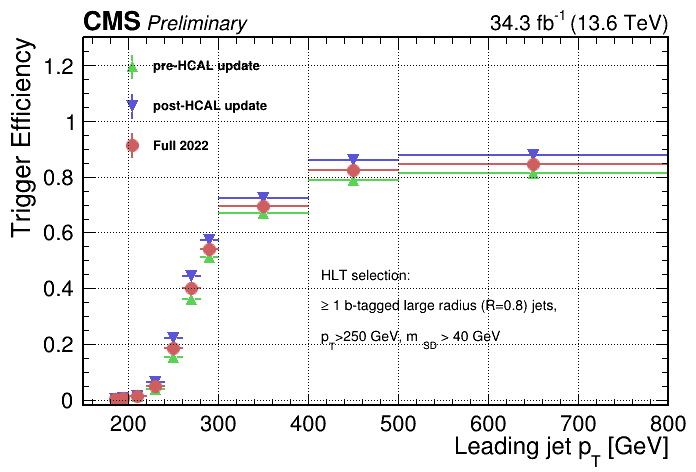

In [61]:
import CMS_lumi, tdrstyle
import array

print(CMS_lumi.__file__)

tdrstyle.setTDRStyle()

#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = "Preliminary"
CMS_lumi.lumi_sqrtS = "34.3 fb^{-1} (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
iPeriod = 0

iPos = 0#11

H_ref = 600; 
W_ref = 800; 
W = W_ref
H  = H_ref

# references for T, B, L, R
T = 0.08*H_ref
B = 0.14*H_ref 
L = 0.12*W_ref
R = 0.04*W_ref


# Draw one plot for test
leg_x0 = 0.51
leg_y0 = 0.15
leg_x1 = 0.89
leg_y1 = 0.5

leg1_x0 = 0.15
leg1_y0 = 0.55
leg1_x1 = 0.49
leg1_y1 = 0.89

leg2_x0 = 0.15
leg2_y0 = 0.15
leg2_x1 = 0.49
leg2_y1 = 0.45

theVar = 'pt1'
theTrig = 'PNetbb'

tgraphs[theTrig]['22CDE'][theVar].SetLineColor(8)
tgraphs[theTrig]['22FG'][theVar].SetLineColor(9)
tgraphs[theTrig]['22all'][theVar].SetLineColor(46)
tgraphs[theTrig]['22CDE'][theVar].SetMarkerColor(8)
tgraphs[theTrig]['22FG'][theVar].SetMarkerColor(9)
tgraphs[theTrig]['22all'][theVar].SetMarkerColor(46)
tgraphs[theTrig]['22CDE'][theVar].SetLineWidth(2)
tgraphs[theTrig]['22FG'][theVar].SetLineWidth(2)
tgraphs[theTrig]['22all'][theVar].SetLineWidth(2)

tgraphs[theTrig]['22CDE'][theVar].SetMarkerStyle(22)
tgraphs[theTrig]['22FG'][theVar].SetMarkerStyle(23)
tgraphs[theTrig]['22all'][theVar].SetMarkerStyle(20)


if 'npv' in theVar:
    path = ROOT.TPaveText(35,0.16,55,0.51)
elif 'tag' in theVar and 'PNet' in theTrig:
    path = ROOT.TPaveText(.6,0.16,0.95,0.51)
elif 'tag' in theVar:
    path = ROOT.TPaveText(0,0,0,0)
else:
    path = ROOT.TPaveText(400,0.16,700,0.51)

path.SetTextAlign(12)
path.SetFillStyle(0)
path.SetBorderSize(0)
path.AddText('HLT selection:')
path.AddText('#geq 1 b-tagged large radius (R=0.8) jets,')
path.AddText('p_{T}>250 GeV, m_{SD} > 40 GeV')  


#print(TRIG_INFO[theTrig]['path'])
#path.SetFontSize(7)
legend = ROOT.TLegend(0.16,0.65,0.4,0.9)
legend.SetFillStyle(0)
legend.SetBorderSize(0)
#legend.SetHeader(TRIG_INFO[theTrig]['path'])
legend.AddEntry( tgraphs[theTrig]['22CDE'][theVar], ERAS['22CDE'], "ep")
legend.AddEntry( tgraphs[theTrig]['22FG'][theVar],  ERAS['22FG'],  "ep")
legend.AddEntry( tgraphs[theTrig]['22all'][theVar], ERAS['22all'], "ep")
canvas=ROOT.TCanvas(TRIG_INFO[theTrig]['path'],"Trigger Efficicency")

canvas.SetFillColor(0)
canvas.SetBorderMode(0)
canvas.SetFrameFillStyle(0)
canvas.SetFrameBorderMode(0)
canvas.SetLeftMargin( L/W )
canvas.SetRightMargin( R/W )
canvas.SetTopMargin( T/H )
canvas.SetBottomMargin( B/H )
canvas.SetTickx()
canvas.SetTicky()
canvas.SetGrid()

#canvas.Update()
#canvas.RedrawAxis()

#anvas.SetGrid()
canvas.cd()

#dummy hist for consistent display

xlow=TRIG_INFO[theTrig]['var_binning'][theVar][0]
xhigh=TRIG_INFO[theTrig]['var_binning'][theVar][-1]
hpx = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3);
hpx.SetStats(False)

hpx.SetTitle(TRIG_INFO[theTrig]['path'])
hpx.GetXaxis().SetTitle(VARLABELS[theVar])
hpx.GetYaxis().SetTitle("Trigger Efficiency")
hpx.GetXaxis().SetTitleSize(0.055)
hpx.GetXaxis().SetTitleOffset(1.1)
hpx.GetYaxis().SetTitleSize(0.06)
hpx.GetYaxis().SetTitleOffset(0.9)
if 'PNet' in theTrig and 'tag' in theVar:
    hpx.GetXaxis().SetTitle(VARLABELS['tag2'])
hpx.Draw()
    
tgraphs[theTrig]['22FG'][theVar].Draw("p same")
tgraphs[theTrig]['22CDE'][theVar].Draw("p same")
tgraphs[theTrig]['22all'][theVar].Draw("p same")
legend.Draw("same")
path.Draw("same")
canvas.Update()
CMS_lumi.CMS_lumi(canvas, iPeriod, iPos)
redrawBorder()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: HLT_AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35_v
Info in <TCanvas::Print>: pdf file test_plots/PNetbb_pt1.newPNetcut.pdf has been created
Info in <TCanvas::Print>: png file test_plots/PNetbb_pt1.newPNetcut.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: HLT_AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35_v
Info in <TCanvas::Print>: pdf file test_plots/PNetbb_tag.newPNetcut.pdf has been created
Info in <TCanvas::Print>: png file test_plots/PNetbb_tag.newPNetcut.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: HLT_AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35_v
Info in <TCanvas::Print>: pdf file test_plots/PNetbb_mass.newPNetcut.pdf has been created
Info in <TCanvas::Print>: png file test_plots/PNetbb_mass.newPNetcut.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: HLT_AK8PFJet250_SoftDropMass

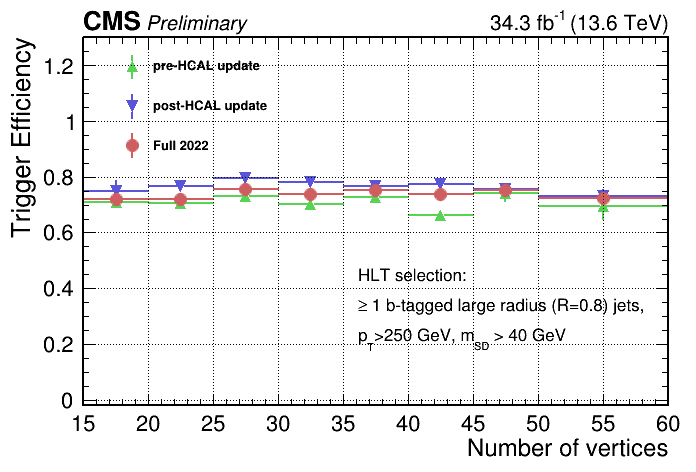

In [67]:
# Draw all plots
for trig in TRIG_INFO:
    for var in TRIG_INFO[trig]['var_binning']:
        


        if 'npv' in var:
            path = ROOT.TPaveText(35,0.16,59,0.51)
        elif 'tag' in var and 'PNet' in trig:
            path = ROOT.TPaveText(.6,0.16,0.99,0.51)
        elif 'tag' in var:
            path = ROOT.TPaveText(0,0,0,0)
        else:
            path = ROOT.TPaveText(400,0.16,750,0.51)
        
        path.SetTextAlign(12)
        path.SetFillStyle(0)
        path.SetBorderSize(0)
        path.AddText('HLT selection:')
        path.AddText('#geq 1 b-tagged large radius (R=0.8) jets,')
        path.AddText('p_{T}>250 GeV, m_{SD} > 40 GeV')  
 
        
        legend = ROOT.TLegend(0.16,0.65,0.4,0.9)
        legend.SetFillStyle(0)
        legend.SetBorderSize(0)
        legend.AddEntry( tgraphs[trig]['22CDE'][var], ERAS['22CDE'], "ep")
        legend.AddEntry( tgraphs[trig]['22FG'][var],  ERAS['22FG'],  "ep")
        legend.AddEntry( tgraphs[trig]['22all'][var], ERAS['22all'], "ep")
        
        canvas=ROOT.TCanvas(TRIG_INFO[trig]['path'],"Trigger Efficiency")
        canvas.SetFillColor(0)
        canvas.SetBorderMode(0)
        canvas.SetFrameFillStyle(0)
        canvas.SetFrameBorderMode(0)
        canvas.SetLeftMargin( L/W )
        canvas.SetRightMargin( R/W )
        canvas.SetTopMargin( T/H )
        canvas.SetBottomMargin( B/H )
        canvas.SetTickx()
        canvas.SetTicky()
        canvas.SetGrid()
        canvas.Update()
        canvas.RedrawAxis()
        canvas.cd()
        
            
        xlow=TRIG_INFO[trig]['var_binning'][var][0]
        xhigh=TRIG_INFO[trig]['var_binning'][var][-1]
        
        hp = ROOT.TH2F(trig+var,"",10,xlow,xhigh,10,-0.02,1.3);
        hp.SetStats(False)        
        hp.SetTitle(TRIG_INFO[trig]['path'])
        hp.GetXaxis().SetTitle(VARLABELS[var])
        hp.GetYaxis().SetTitle("Trigger Efficiency")
        hp.GetXaxis().SetTitleSize(0.055)
        hp.GetXaxis().SetTitleOffset(1.0)
        hp.GetYaxis().SetTitleSize(0.06)
        hp.GetYaxis().SetTitleOffset(0.9)
        if 'PNet' in trig and 'tag' in var:
            hp.GetXaxis().SetTitle(VARLABELS['tag2'])
        hp.Draw()
    
        tgraphs[trig]['22CDE'][var].SetLineColor(8)
        tgraphs[trig]['22FG'][var].SetLineColor(9)
        tgraphs[trig]['22all'][var].SetLineColor(46)
        tgraphs[trig]['22CDE'][var].SetMarkerColor(8)
        tgraphs[trig]['22FG'][var].SetMarkerColor(9)
        tgraphs[trig]['22all'][var].SetMarkerColor(46)
        tgraphs[trig]['22CDE'][var].SetLineWidth(2)
        tgraphs[trig]['22FG'][var].SetLineWidth(2)
        tgraphs[trig]['22all'][var].SetLineWidth(2)
        tgraphs[trig]['22CDE'][var].SetMarkerStyle(22)
        tgraphs[trig]['22FG'][var].SetMarkerStyle(23)
        tgraphs[trig]['22all'][var].SetMarkerStyle(20)
        
        tgraphs[trig]['22FG'][var].Draw("p same")
        tgraphs[trig]['22CDE'][var].Draw("p same")
        tgraphs[trig]['22all'][var].Draw("p same")
        legend.Draw("same")
        path.Draw("same")
        CMS_lumi.CMS_lumi(canvas, iPeriod, iPos)
        
        redrawBorder()
        canvas.Draw()
        
        canvas.SaveAs("test_plots/{}_{}.newPNetcut.pdf".format(trig,var))
        canvas.SaveAs("test_plots/{}_{}.newPNetcut.png".format(trig,var))
        
#        break
#    break


In [65]:
!pwd

/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod
